In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/llm-classification-finetuning/sample_submission.csv
/kaggle/input/llm-classification-finetuning/train.csv
/kaggle/input/llm-classification-finetuning/test.csv


Libraries imported successfully!
Dataset Shapes:
Train: (57477, 9)
Test: (3, 4)
Sample Submission: (3, 4)

TRAINING DATA OVERVIEW

Column Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57477 entries, 0 to 57476
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              57477 non-null  int64 
 1   model_a         57477 non-null  object
 2   model_b         57477 non-null  object
 3   prompt          57477 non-null  object
 4   response_a      57477 non-null  object
 5   response_b      57477 non-null  object
 6   winner_model_a  57477 non-null  int64 
 7   winner_model_b  57477 non-null  int64 
 8   winner_tie      57477 non-null  int64 
dtypes: int64(4), object(5)
memory usage: 3.9+ MB
None

First few rows:
       id             model_a              model_b  \
0   30192  gpt-4-1106-preview           gpt-4-0613   
1   53567           koala-13b           gpt-4-0613   
2   65089  gpt-3.5-turb

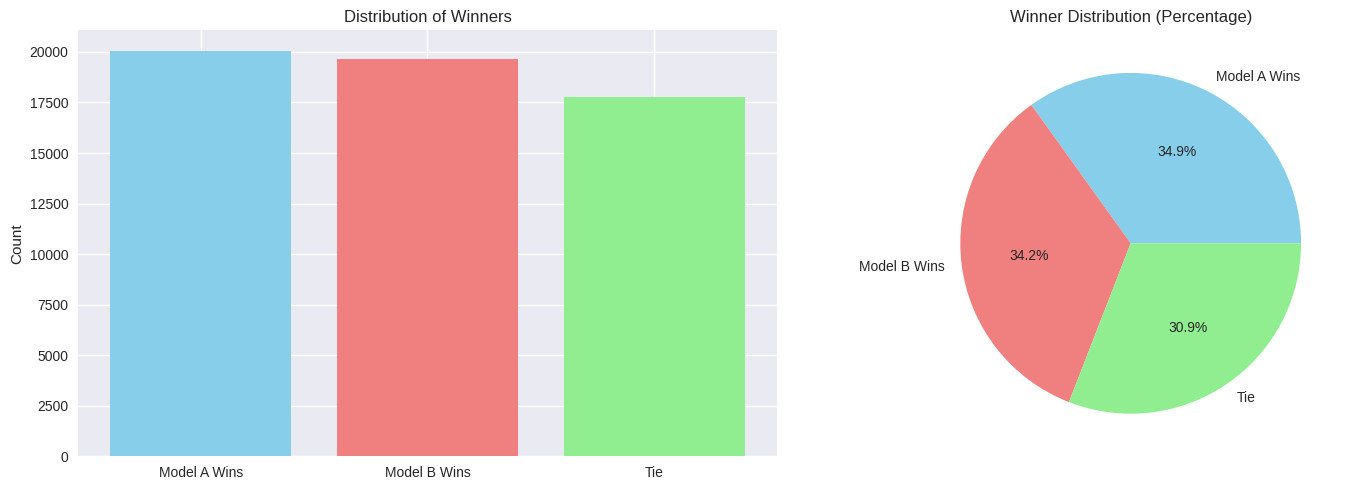


Text Length Statistics:
Average prompt length: 369.2
Average response A length: 1377.8
Average response B length: 1386.2


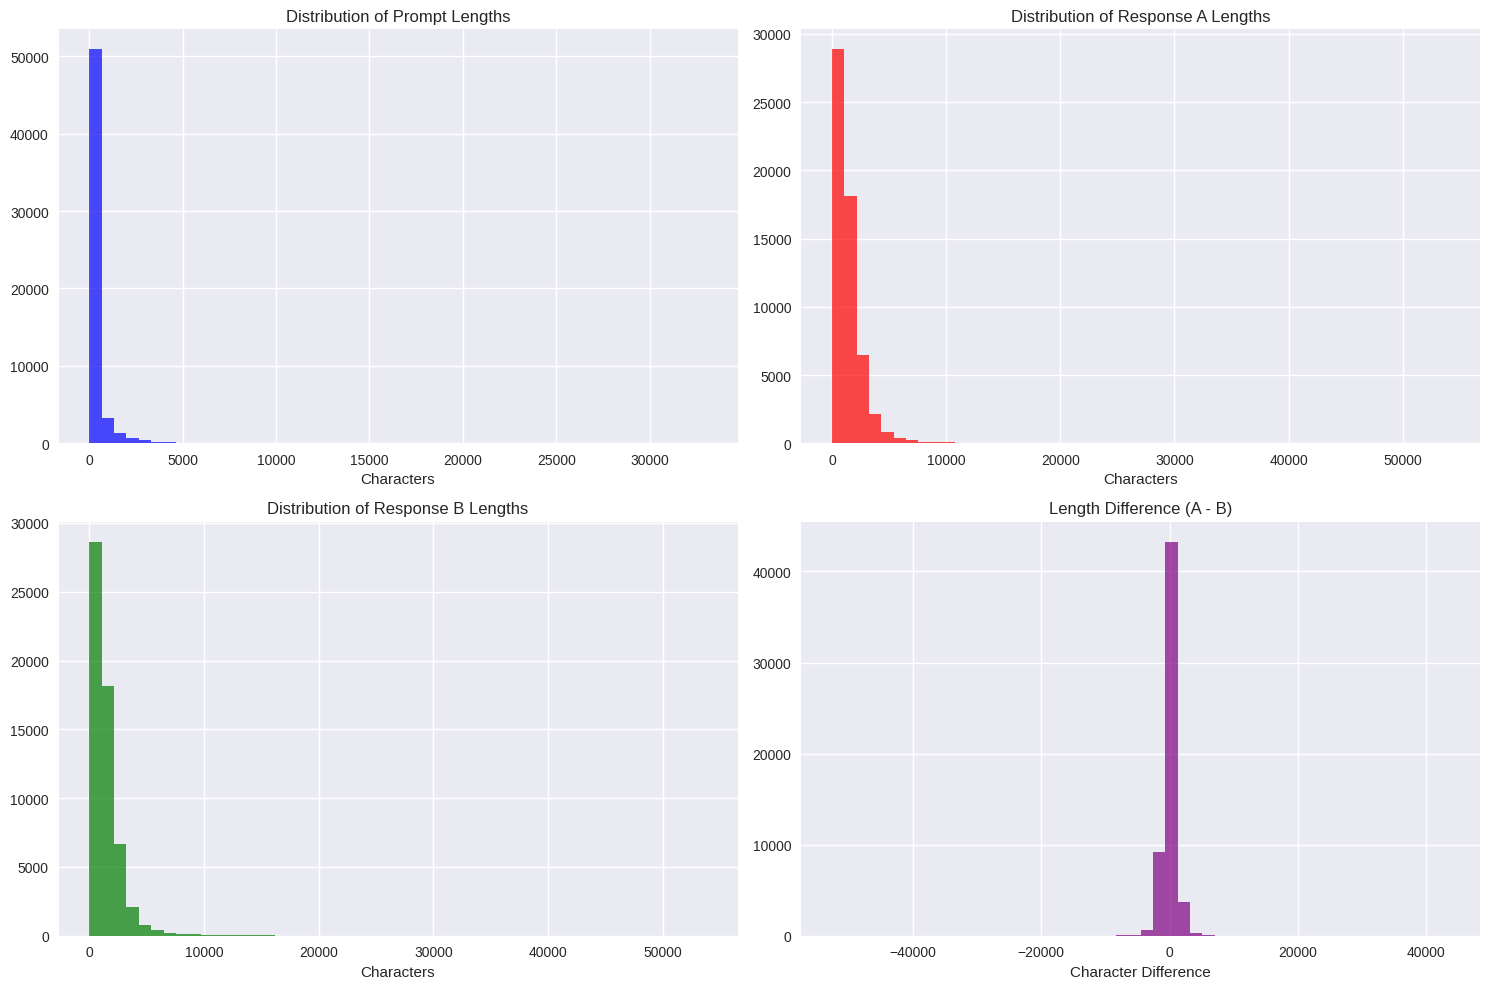


Unique Models:
Total unique models: 64
Models: ['nous-hermes-2-mixtral-8x7b-dpo', 'oasst-pythia-12b', 'mistral-7b-instruct-v0.2', 'vicuna-13b', 'llama-2-70b-chat', 'gpt4all-13b-snoozy', 'gpt-4-0314', 'claude-2.1', 'gemini-pro-dev-api', 'qwen1.5-7b-chat']

FEATURE ENGINEERING
Feature engineering completed!
Number of features created: 15

TEXT VECTORIZATION
Creating TF-IDF features...
TF-IDF shape: (57477, 5000)
Combined features shape: (57477, 5015)

MODEL TRAINING
Training set: (45981, 5015)
Validation set: (11496, 5015)

Training Logistic Regression...
Logistic Regression Log Loss: 1.0720

Training Random Forest...
Random Forest Log Loss: 1.0674
Ensemble Log Loss: 1.0655

CROSS-VALIDATION
Fold 1/5...
Fold 1 Log Loss: 1.0664
Fold 2/5...
Fold 2 Log Loss: 1.0661
Fold 3/5...
Fold 3 Log Loss: 1.0657
Fold 4/5...
Fold 4 Log Loss: 1.0663
Fold 5/5...
Fold 5 Log Loss: 1.0653

Cross-validation results:
Mean CV Score: 1.0659 (+/- 0.0009)

FINAL MODEL TRAINING
Training final Logistic Regression..

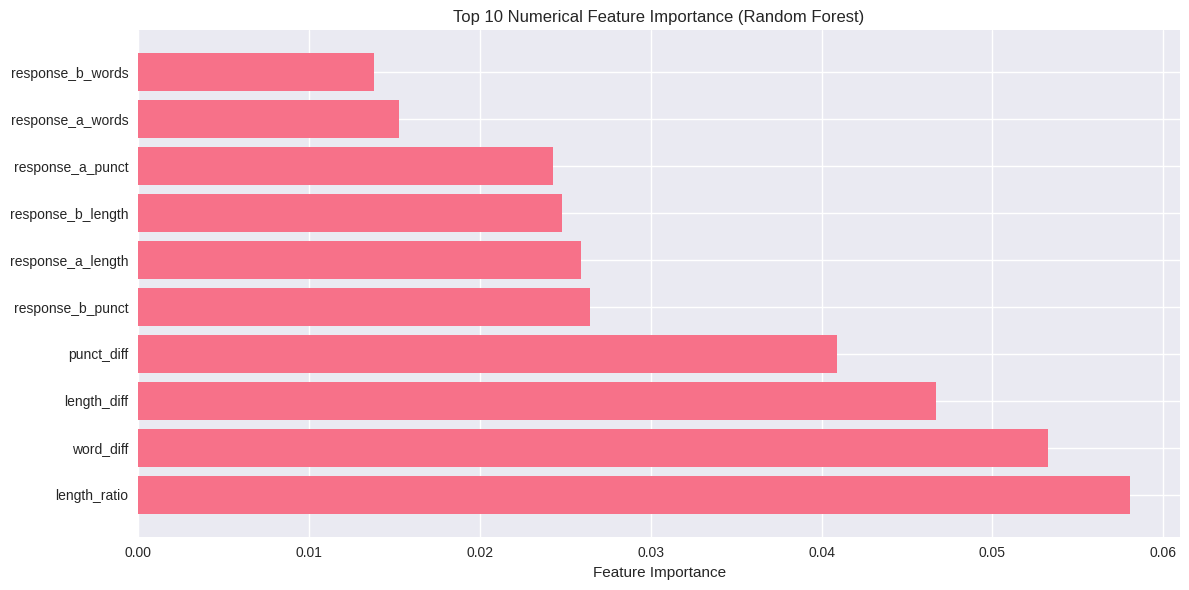


ANALYSIS COMPLETE!
Expected CV Score: 1.0659
Submission file 'submission.csv' is ready for upload!


In [2]:
# LLM Classification Finetuning - Predicting Human Preferences
# Kaggle Competition: https://www.kaggle.com/competitions/llm-classification-finetuning

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss, accuracy_score
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")

# =============================================================================
# DATA LOADING AND INITIAL EXPLORATION
# =============================================================================

# Load the training data
train_df = pd.read_csv('/kaggle/input/llm-classification-finetuning/train.csv')
test_df = pd.read_csv('/kaggle/input/llm-classification-finetuning/test.csv')
sample_submission = pd.read_csv('/kaggle/input/llm-classification-finetuning/sample_submission.csv')

print("Dataset Shapes:")
print(f"Train: {train_df.shape}")
print(f"Test: {test_df.shape}")
print(f"Sample Submission: {sample_submission.shape}")

print("\n" + "="*50)
print("TRAINING DATA OVERVIEW")
print("="*50)

print("\nColumn Information:")
print(train_df.info())

print("\nFirst few rows:")
print(train_df.head())

print("\nTarget Distribution:")
target_cols = ['winner_model_a', 'winner_model_b', 'winner_tie']
for col in target_cols:
    print(f"{col}: {train_df[col].sum()} ({train_df[col].mean():.3f})")

print("\nBasic Statistics:")
print(train_df.describe())

# =============================================================================
# DATA EXPLORATION AND VISUALIZATION
# =============================================================================

print("\n" + "="*50)
print("DATA EXPLORATION")
print("="*50)

# Check for missing values
print("\nMissing Values:")
print(train_df.isnull().sum())

# Target distribution visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Target distribution
target_counts = [train_df['winner_model_a'].sum(), 
                 train_df['winner_model_b'].sum(), 
                 train_df['winner_tie'].sum()]
target_labels = ['Model A Wins', 'Model B Wins', 'Tie']

axes[0].bar(target_labels, target_counts, color=['skyblue', 'lightcoral', 'lightgreen'])
axes[0].set_title('Distribution of Winners')
axes[0].set_ylabel('Count')

# Pie chart
axes[1].pie(target_counts, labels=target_labels, autopct='%1.1f%%', 
           colors=['skyblue', 'lightcoral', 'lightgreen'])
axes[1].set_title('Winner Distribution (Percentage)')

plt.tight_layout()
plt.show()

# Text length analysis
train_df['prompt_length'] = train_df['prompt'].str.len()
train_df['response_a_length'] = train_df['response_a'].str.len()
train_df['response_b_length'] = train_df['response_b'].str.len()
train_df['length_diff'] = train_df['response_a_length'] - train_df['response_b_length']

print(f"\nText Length Statistics:")
print(f"Average prompt length: {train_df['prompt_length'].mean():.1f}")
print(f"Average response A length: {train_df['response_a_length'].mean():.1f}")
print(f"Average response B length: {train_df['response_b_length'].mean():.1f}")

# Visualize text lengths
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0,0].hist(train_df['prompt_length'], bins=50, alpha=0.7, color='blue')
axes[0,0].set_title('Distribution of Prompt Lengths')
axes[0,0].set_xlabel('Characters')

axes[0,1].hist(train_df['response_a_length'], bins=50, alpha=0.7, color='red')
axes[0,1].set_title('Distribution of Response A Lengths')
axes[0,1].set_xlabel('Characters')

axes[1,0].hist(train_df['response_b_length'], bins=50, alpha=0.7, color='green')
axes[1,0].set_title('Distribution of Response B Lengths')
axes[1,0].set_xlabel('Characters')

axes[1,1].hist(train_df['length_diff'], bins=50, alpha=0.7, color='purple')
axes[1,1].set_title('Length Difference (A - B)')
axes[1,1].set_xlabel('Character Difference')

plt.tight_layout()
plt.show()

# Model analysis (if available in training data)
if 'model_a' in train_df.columns and 'model_b' in train_df.columns:
    print(f"\nUnique Models:")
    all_models = list(train_df['model_a'].unique()) + list(train_df['model_b'].unique())
    unique_models = list(set(all_models))
    print(f"Total unique models: {len(unique_models)}")
    print("Models:", unique_models[:10])  # Show first 10

# =============================================================================
# FEATURE ENGINEERING
# =============================================================================

print("\n" + "="*50)
print("FEATURE ENGINEERING")
print("="*50)

def create_features(df):
    """Create features for the model"""
    
    # Text length features
    df['prompt_length'] = df['prompt'].str.len()
    df['response_a_length'] = df['response_a'].str.len()
    df['response_b_length'] = df['response_b'].str.len()
    df['length_diff'] = df['response_a_length'] - df['response_b_length']
    df['length_ratio'] = df['response_a_length'] / (df['response_b_length'] + 1)
    
    # Word count features
    df['prompt_words'] = df['prompt'].str.split().str.len()
    df['response_a_words'] = df['response_a'].str.split().str.len()
    df['response_b_words'] = df['response_b'].str.split().str.len()
    df['word_diff'] = df['response_a_words'] - df['response_b_words']
    
    # Punctuation features
    df['response_a_punct'] = df['response_a'].str.count(r'[.!?]')
    df['response_b_punct'] = df['response_b'].str.count(r'[.!?]')
    df['punct_diff'] = df['response_a_punct'] - df['response_b_punct']
    
    # Question features
    df['prompt_questions'] = df['prompt'].str.count(r'\?')
    df['response_a_questions'] = df['response_a'].str.count(r'\?')
    df['response_b_questions'] = df['response_b'].str.count(r'\?')
    
    # Combined text for TF-IDF
    df['combined_text'] = df['prompt'] + " [SEP] " + df['response_a'] + " [SEP] " + df['response_b']
    
    return df

# Apply feature engineering
train_df = create_features(train_df)
test_df = create_features(test_df)

# Create target variable for multi-class classification
def get_winner_label(row):
    if row['winner_model_a'] == 1:
        return 0  # Model A wins
    elif row['winner_model_b'] == 1:
        return 1  # Model B wins
    else:
        return 2  # Tie

train_df['winner_label'] = train_df.apply(get_winner_label, axis=1)

print("Feature engineering completed!")
print(f"Number of features created: {len([col for col in train_df.columns if col.endswith(('_length', '_words', '_punct', '_questions', '_diff', '_ratio'))])}")

# =============================================================================
# TEXT VECTORIZATION
# =============================================================================

print("\n" + "="*50)
print("TEXT VECTORIZATION")
print("="*50)

# Prepare numerical features
numerical_features = [
    'prompt_length', 'response_a_length', 'response_b_length', 
    'length_diff', 'length_ratio', 'prompt_words', 'response_a_words', 
    'response_b_words', 'word_diff', 'response_a_punct', 'response_b_punct',
    'punct_diff', 'prompt_questions', 'response_a_questions', 'response_b_questions'
]

X_numerical = train_df[numerical_features].fillna(0)
X_numerical_test = test_df[numerical_features].fillna(0)

# TF-IDF Vectorization
print("Creating TF-IDF features...")
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    stop_words='english',
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.95
)

X_tfidf = tfidf_vectorizer.fit_transform(train_df['combined_text'])
X_tfidf_test = tfidf_vectorizer.transform(test_df['combined_text'])

print(f"TF-IDF shape: {X_tfidf.shape}")

# Combine features
from scipy.sparse import hstack, csr_matrix

X_combined = hstack([csr_matrix(X_numerical), X_tfidf])
X_combined_test = hstack([csr_matrix(X_numerical_test), X_tfidf_test])

print(f"Combined features shape: {X_combined.shape}")

# =============================================================================
# MODEL TRAINING AND VALIDATION
# =============================================================================

print("\n" + "="*50)
print("MODEL TRAINING")
print("="*50)

# Prepare targets
y = train_df['winner_label']
y_multiclass = train_df[target_cols].values

# Split for validation
X_train, X_val, y_train_multi, y_val_multi = train_test_split(
    X_combined, y_multiclass, test_size=0.2, random_state=42, stratify=y
)

# Also split the 1D labels for the models that need them
_, _, y_train_1d, y_val_1d = train_test_split(
    X_combined, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")

# Model 1: Logistic Regression (uses 1D labels)
print("\nTraining Logistic Regression...")
lr_model = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',
    max_iter=1000,
    random_state=42,
    class_weight='balanced'
)

lr_model.fit(X_train, y_train_1d)
lr_pred = lr_model.predict_proba(X_val)

lr_loss = log_loss(y_val_multi, lr_pred)
print(f"Logistic Regression Log Loss: {lr_loss:.4f}")

# Model 2: Random Forest (uses 1D labels)
print("\nTraining Random Forest...")
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)

rf_model.fit(X_train, y_train_1d)
rf_pred = rf_model.predict_proba(X_val)

rf_loss = log_loss(y_val_multi, rf_pred)
print(f"Random Forest Log Loss: {rf_loss:.4f}")

# Ensemble prediction
ensemble_pred = (lr_pred + rf_pred) / 2
ensemble_loss = log_loss(y_val_multi, ensemble_pred)
print(f"Ensemble Log Loss: {ensemble_loss:.4f}")

# =============================================================================
# CROSS-VALIDATION
# =============================================================================

print("\n" + "="*50)
print("CROSS-VALIDATION")
print("="*50)

# 5-fold cross-validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []

for fold, (train_idx, val_idx) in enumerate(kfold.split(X_combined, y)):
    print(f"Fold {fold + 1}/5...")
    
    X_tr, X_vl = X_combined[train_idx], X_combined[val_idx]
    y_tr_1d, y_vl_1d = y[train_idx], y[val_idx]
    y_tr_multi, y_vl_multi = y_multiclass[train_idx], y_multiclass[val_idx]
    
    # Train models (use 1D labels for fitting)
    lr_temp = LogisticRegression(multi_class='multinomial', solver='lbfgs', 
                                max_iter=1000, random_state=42, class_weight='balanced')
    lr_temp.fit(X_tr, y_tr_1d)
    lr_pred_temp = lr_temp.predict_proba(X_vl)
    
    rf_temp = RandomForestClassifier(n_estimators=100, max_depth=10, 
                                   random_state=42, class_weight='balanced', n_jobs=-1)
    rf_temp.fit(X_tr, y_tr_1d)
    rf_pred_temp = rf_temp.predict_proba(X_vl)
    
    # Ensemble (evaluate against multi-class format)
    ensemble_pred_temp = (lr_pred_temp + rf_pred_temp) / 2
    fold_score = log_loss(y_vl_multi, ensemble_pred_temp)
    cv_scores.append(fold_score)
    
    print(f"Fold {fold + 1} Log Loss: {fold_score:.4f}")

print(f"\nCross-validation results:")
print(f"Mean CV Score: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores) * 2:.4f})")

# =============================================================================
# FINAL MODEL TRAINING
# =============================================================================

print("\n" + "="*50)
print("FINAL MODEL TRAINING")
print("="*50)

# Train final models on full dataset
print("Training final Logistic Regression...")
final_lr = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',
    max_iter=1000,
    random_state=42,
    class_weight='balanced'
)
final_lr.fit(X_combined, y)  # Use 1D labels for fitting

print("Training final Random Forest...")
final_rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)
final_rf.fit(X_combined, y)  # Use 1D labels for fitting

print("Final models trained successfully!")

# =============================================================================
# PREDICTIONS AND SUBMISSION
# =============================================================================

print("\n" + "="*50)
print("GENERATING PREDICTIONS")
print("="*50)

# Generate predictions on test set
lr_test_pred = final_lr.predict_proba(X_combined_test)
rf_test_pred = final_rf.predict_proba(X_combined_test)

# Ensemble prediction
final_pred = (lr_test_pred + rf_test_pred) / 2

print(f"Prediction shape: {final_pred.shape}")
print(f"Sample predictions (first 5 rows):")
print(final_pred[:5])

# Create submission dataframe
submission = pd.DataFrame({
    'id': test_df['id'],
    'winner_model_a': final_pred[:, 0],
    'winner_model_b': final_pred[:, 1],
    'winner_tie': final_pred[:, 2]
})

# Verify submission format
print(f"\nSubmission shape: {submission.shape}")
print("Submission head:")
print(submission.head())

# Check that probabilities sum to 1
prob_sums = submission[['winner_model_a', 'winner_model_b', 'winner_tie']].sum(axis=1)
print(f"\nProbability sums check (should be ~1.0): {prob_sums.describe()}")

# Save submission
submission.to_csv('submission.csv', index=False)
print("\nSubmission saved as 'submission.csv'")

# =============================================================================
# FEATURE IMPORTANCE ANALYSIS
# =============================================================================

print("\n" + "="*50)
print("FEATURE IMPORTANCE")
print("="*50)

# Get feature importance from Random Forest
feature_names = numerical_features + [f'tfidf_{i}' for i in range(X_tfidf.shape[1])]
rf_importance = final_rf.feature_importances_

# Top numerical features
numerical_importance = rf_importance[:len(numerical_features)]
top_numerical_idx = np.argsort(numerical_importance)[-10:][::-1]

print("Top 10 Numerical Features:")
for idx in top_numerical_idx:
    print(f"{numerical_features[idx]}: {numerical_importance[idx]:.4f}")

# Visualization
plt.figure(figsize=(12, 6))
plt.barh(range(len(top_numerical_idx)), numerical_importance[top_numerical_idx])
plt.yticks(range(len(top_numerical_idx)), [numerical_features[i] for i in top_numerical_idx])
plt.xlabel('Feature Importance')
plt.title('Top 10 Numerical Feature Importance (Random Forest)')
plt.tight_layout()
plt.show()

print("\n" + "="*50)
print("ANALYSIS COMPLETE!")
print("="*50)
print(f"Expected CV Score: {np.mean(cv_scores):.4f}")
print("Submission file 'submission.csv' is ready for upload!")
print("="*50)